##  導入程式庫

In [1]:
import torch
import torchvision
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
from torchvision.transforms import transforms
import numpy as np
import torchvision.utils as vutils
import PIL.Image as Image

##  加載MNIST資料

In [2]:
# 下載並匯入 MNIST 訓練資料
train_data = torchvision.datasets.MNIST("MNIST/", train=True, transform=None,target_transform=None,download=True)

# 下載並匯入 MNIST 測試資料
test_data = torchvision.datasets.MNIST("MNIST/", train=False, transform=None,target_transform=None,download=True)

# 印出資料數
print('Number of train_data is: ',len(train_data))
print('Number of test_data is: ',len(test_data))

Number of train_data is:  60000
Number of test_data is:  10000


## 變數基本宣告

In [3]:
# 設定 CUDA
use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")

# Filter train data for labels 1, 3, 5, 7
filtered_train_indices = torch.where((train_data.targets == 1) | (train_data.targets == 3) | (train_data.targets == 5) | (train_data.targets == 7))[0]
filtered_train_data = train_data.data[filtered_train_indices]
filtered_train_targets = train_data.targets[filtered_train_indices]

# normalization
X_train_normal = filtered_train_data.float() / 255
X_test_normal = test_data.data.float() / 255

# 切割訓練資料 (7:3)
train_x, val_x, train_y, val_y = train_test_split(X_train_normal, filtered_train_targets, test_size=0.3, random_state=42)

# Set Hyper Parameters
LR = 0.01
batch_size = 32
n_iters = 5000
num_epochs = n_iters / (len(train_x) / batch_size)
num_epochs = int(num_epochs)
input_shape = (-1,1,28,28)
image_size = (28*28)

# 將 data 跟 targets 組合為 Dataset 對象
train_dataset = TensorDataset(train_x, train_y)
val_dataset = TensorDataset(val_x, val_y)
test_dataset = TensorDataset(X_test_normal, test_data.targets)

# 將 Dataset 對象轉換為 DataLoader 對象，方便批量加載和處理數據
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

##  Image Classifier（第一小題）

In [4]:
# 定義 CNN model 架構
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1,16,kernel_size=(3,3)) # 第一卷積層
        self.dropout1 = nn.Dropout2d(0.25)  # 添加 dropout 層
        self.conv2 = nn.Conv2d(16,32,kernel_size=(3,3))
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2)) # 最大池化層
        self.dropout2 = nn.Dropout2d(0.25)  # 添加 dropout 層
        self.lin1 = nn.Linear(800,128)
        self.out = nn.Linear(128,10) # 模型的最後一層為線性層，用來處理 CNN 扁平化後的輸出
    
    def forward(self,x):
        x = self.conv1(x)
        x = nn.functional.relu(x) # 選用 ReLU 為激活函數
        x = self.dropout1(x)  # 添加 dropout 層
        x = self.maxpool(x)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = self.dropout2(x)  # 添加 dropout 層
        x = self.maxpool(x)
        x = x.flatten(start_dim=1) # 扁平化
        x = self.lin1(x) 
        x = nn.functional.relu(x)
        x = self.out(x)
        x = nn.functional.log_softmax(x,dim=1) # 使用 log_softmax()，以機率的形式進行分類
        return x

# 初始化 CNN model
model = CNN()
print(model)

loss_func_cross = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout2d(p=0.25, inplace=False)
  (lin1): Linear(in_features=800, out_features=128, bias=True)
  (out): Linear(in_features=128, out_features=10, bias=True)
)


In [5]:
# 定義 fit_model
def fit_model(model, loss_func, optimizer, input_shape, num_epochs, train_loader, val_loader):
    
    # Traning the Model
    # history-like list for store loss & acc value
    training_loss = []
    training_accuracy = []
    validation_loss = []
    validation_accuracy = []
    
    #training model & store loss & acc / epoch
    for epoch in range(num_epochs):
        correct_train = 0
        total_train = 0
        
        for i, (images, labels) in enumerate(train_loader):
            
            inputs = images.view(input_shape).to(device)
            # Clear gradients
            optimizer.zero_grad()
            # Forward propagation
            outputs = model(inputs)
            # Calculate softmax and cross entropy loss
            train_loss = loss_func(outputs, labels)
            # Calculate gradients
            train_loss.backward()
            # Update parameters
            optimizer.step()
            # Get predictions from the maximum value
            predicted = torch.max(outputs.data, 1)[1]
            # Total number of labels
            total_train += len(labels)
            # Total correct predictions
            correct_train += (predicted == labels).float().sum()
            
        # store val_acc / epoch
        train_accuracy = 100 * correct_train / float(total_train)
        training_accuracy.append(train_accuracy)
        # store loss / epoch
        training_loss.append(train_loss.data)

        # evaluate model & store loss & acc / epoch
        correct_test = 0
        total_test = 0
        
        for images, labels in val_loader:
            
            inputs = images.view(input_shape).to(device)
            # Forward propagation
            outputs = model(inputs)
            # Calculate softmax and cross entropy loss
            val_loss = loss_func(outputs, labels)
            # Get predictions from the maximum value
            predicted = torch.max(outputs.data, 1)[1]
            # Total number of labels
            total_test += len(labels)
            # Total correct predictions
            correct_test += (predicted == labels).float().sum()
            
        # store val_acc / epoch
        val_accuracy = 100 * correct_test / float(total_test)
        validation_accuracy.append(val_accuracy)
        # store val_loss / epoch
        validation_loss.append(val_loss.data)
        
        print('Train Epoch: {}/{} Traing_acc: {:.6f}% Traing_Loss: {:.6f} Val_acc: {:.6f}% Val_Loss: {:.6f}'.format(epoch+1, num_epochs, train_accuracy, train_loss.data, val_accuracy, val_loss.data))
    return training_loss, training_accuracy, validation_loss, validation_accuracy

In [6]:
training_loss, training_accuracy, validation_loss, validation_accuracy = fit_model(model, loss_func_cross, optimizer, input_shape, num_epochs, train_loader, val_loader)

Train Epoch: 1/9 Traing_acc: 94.712349% Traing_Loss: 0.013568 Val_acc: 98.262756% Val_Loss: 0.093847
Train Epoch: 2/9 Traing_acc: 97.946602% Traing_Loss: 0.001433 Val_acc: 98.656349% Val_Loss: 0.062715
Train Epoch: 3/9 Traing_acc: 98.173462% Traing_Loss: 0.000613 Val_acc: 98.588493% Val_Loss: 0.019173
Train Epoch: 4/9 Traing_acc: 98.388695% Traing_Loss: 0.001384 Val_acc: 98.547775% Val_Loss: 1.230921
Train Epoch: 5/9 Traing_acc: 98.475945% Traing_Loss: 0.000635 Val_acc: 98.819221% Val_Loss: 0.026065
Train Epoch: 6/9 Traing_acc: 98.330521% Traing_Loss: 0.000280 Val_acc: 97.869164% Val_Loss: 0.000279
Train Epoch: 7/9 Traing_acc: 98.545753% Traing_Loss: 0.215904 Val_acc: 98.520630% Val_Loss: 0.000279
Train Epoch: 8/9 Traing_acc: 98.400322% Traing_Loss: 0.002257 Val_acc: 98.412048% Val_Loss: 0.039509
Train Epoch: 9/9 Traing_acc: 98.691177% Traing_Loss: 0.003051 Val_acc: 98.574921% Val_Loss: 0.053121


In [7]:
# 評估模型並尋找 Threshold
def test_model(model, loss_func, input_shape, test_loader):
    threshold = 0
    best_acc = 0
    best_thres = 0
    
    for i in range(100):

        threshold = 0.995 + 0.005 * (i/100)
        
        with torch.no_grad():  # 禁用梯度計算
            model.eval()
            correct = 0
            total = 0
            test_loss = 0
            abnormal_count = 0  # 紀錄異常數量
            
            for images, labels in test_loader:
                
                inputs = images.view(input_shape).to(device)
                
                # 將數據傳入模型
                outputs = model(inputs)
                
                # 計算損失
                test_loss += loss_func(outputs, labels).item()
                
                # 獲取預測結果
                predicted = torch.max(outputs.data, 1)[1]
                
                # 統計正確預測的數量
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                # 判斷是否為異常
                probabilities = torch.softmax(outputs, dim=1)
                for i, prob in enumerate(probabilities):
                    if labels[i] not in [1, 3, 5, 7] and prob.max() < threshold:  # 當預測機率低於閾值且真實標籤非正常類別時，視為異常
                        abnormal_count += 1

            accuracy = 100 * (correct + abnormal_count) / total  # 將正確預測到異常值也加入計算
            if accuracy > best_acc:
                best_acc = accuracy
                best_thres = threshold
            print('Accuracy: {:.2f}%, Threshold: {:.6f}'.format(accuracy, threshold))
    return best_acc, best_thres
    
# 使用測試函數對模型進行評估
accuracy_clasify, best_threshold_clasify = test_model(model, loss_func_cross, input_shape, test_loader)
print('Best Accuracy: {:.2f}%, Threshold: {:.6f}'.format(accuracy_clasify, best_threshold_clasify))

Accuracy: 79.18%, Threshold: 0.995000
Accuracy: 79.21%, Threshold: 0.995050
Accuracy: 79.26%, Threshold: 0.995100
Accuracy: 79.34%, Threshold: 0.995150
Accuracy: 79.39%, Threshold: 0.995200
Accuracy: 79.44%, Threshold: 0.995250
Accuracy: 79.49%, Threshold: 0.995300
Accuracy: 79.53%, Threshold: 0.995350
Accuracy: 79.59%, Threshold: 0.995400
Accuracy: 79.66%, Threshold: 0.995450
Accuracy: 79.70%, Threshold: 0.995500
Accuracy: 79.76%, Threshold: 0.995550
Accuracy: 79.84%, Threshold: 0.995600
Accuracy: 79.86%, Threshold: 0.995650
Accuracy: 79.95%, Threshold: 0.995700
Accuracy: 79.99%, Threshold: 0.995750
Accuracy: 80.05%, Threshold: 0.995800
Accuracy: 80.09%, Threshold: 0.995850
Accuracy: 80.20%, Threshold: 0.995900
Accuracy: 80.27%, Threshold: 0.995950
Accuracy: 80.34%, Threshold: 0.996000
Accuracy: 80.37%, Threshold: 0.996050
Accuracy: 80.46%, Threshold: 0.996100
Accuracy: 80.53%, Threshold: 0.996150
Accuracy: 80.55%, Threshold: 0.996200
Accuracy: 80.62%, Threshold: 0.996250
Accuracy: 80

## Autoencoder（第二小題）

In [8]:
# Model structure
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.Tanh(),
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64, 36),
            nn.Tanh(),
            nn.Linear(36, 18),
            nn.Tanh(),
            nn.Linear(18, 9)
        )
        self.decoder = nn.Sequential(
            nn.Linear(9, 18),
            nn.Tanh(),
            nn.Linear(18, 36),
            nn.Tanh(),
            nn.Linear(36, 64),
            nn.Tanh(),
            nn.Linear(64, 128),
            nn.Tanh(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
model_ae = AutoEncoder().to(device)

print(model_ae)

loss_func_mse = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model_ae.parameters(), lr=LR)

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=36, bias=True)
    (5): Tanh()
    (6): Linear(in_features=36, out_features=18, bias=True)
    (7): Tanh()
    (8): Linear(in_features=18, out_features=9, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=9, out_features=18, bias=True)
    (1): Tanh()
    (2): Linear(in_features=18, out_features=36, bias=True)
    (3): Tanh()
    (4): Linear(in_features=36, out_features=64, bias=True)
    (5): Tanh()
    (6): Linear(in_features=64, out_features=128, bias=True)
    (7): Tanh()
    (8): Linear(in_features=128, out_features=784, bias=True)
    (9): Sigmoid()
  )
)


In [9]:
def fit_model(model, loss_func, optimizer, num_epochs, train_loader, val_loader):
    # Traning the Model
    #history-like list for store loss & acc value
    training_loss = []
    validation_loss = []
    for epoch in range(num_epochs):
        #training model & store loss & acc / epoch
        correct_train = 0
        total_train = 0
        for i, (images, labels) in enumerate(train_loader):
            inputs = images.view(-1, image_size).to(device) 
            
            # 2.Clear gradients
            optimizer.zero_grad()
            # 3.Forward propagation
            outputs = model(inputs)
            # 4.Calculate softmax and cross entropy loss
            train_loss = loss_func(outputs, inputs)
            # 5.Calculate gradients
            train_loss.backward()
            # 6.Update parameters
            optimizer.step()
        
        # 11.store loss / epoch
        training_loss.append(train_loss.data)

        #evaluate model & store loss & acc / epoch
        correct_test = 0
        total_test = 0
        for images, _ in val_loader:
            inputs = images.view(-1, image_size).to(device) 
            outputs = model(inputs)
            val_loss = loss_func(outputs, inputs)
            
        # 11.store val_loss / epoch
        validation_loss.append(val_loss.data)
        print('Train Epoch: {}/{} Traing_Loss: {:.6f} Val_Loss: {:.6f}'.format(epoch+1, num_epochs, train_loss.data, val_loss.data))
    return training_loss, validation_loss

In [10]:
training_loss, validation_loss = fit_model(model_ae, loss_func_mse, optimizer, num_epochs, train_loader, val_loader)

Train Epoch: 1/9 Traing_Loss: 0.062235 Val_Loss: 0.058809
Train Epoch: 2/9 Traing_Loss: 0.060749 Val_Loss: 0.058533
Train Epoch: 3/9 Traing_Loss: 0.055338 Val_Loss: 0.054151
Train Epoch: 4/9 Traing_Loss: 0.067040 Val_Loss: 0.056008
Train Epoch: 5/9 Traing_Loss: 0.055292 Val_Loss: 0.041463
Train Epoch: 6/9 Traing_Loss: 0.047899 Val_Loss: 0.062777
Train Epoch: 7/9 Traing_Loss: 0.051180 Val_Loss: 0.063070
Train Epoch: 8/9 Traing_Loss: 0.050768 Val_Loss: 0.066895
Train Epoch: 9/9 Traing_Loss: 0.066174 Val_Loss: 0.052623


Original Images


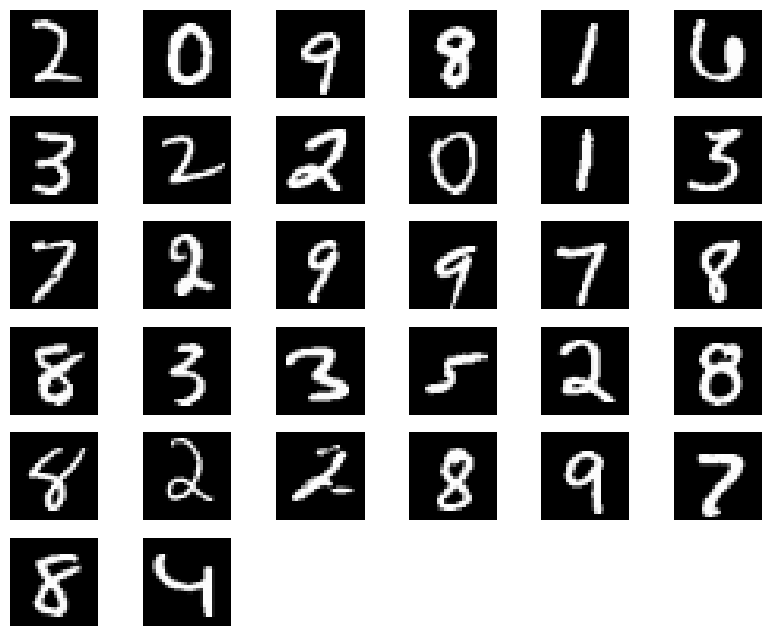

Restructured Image by AE


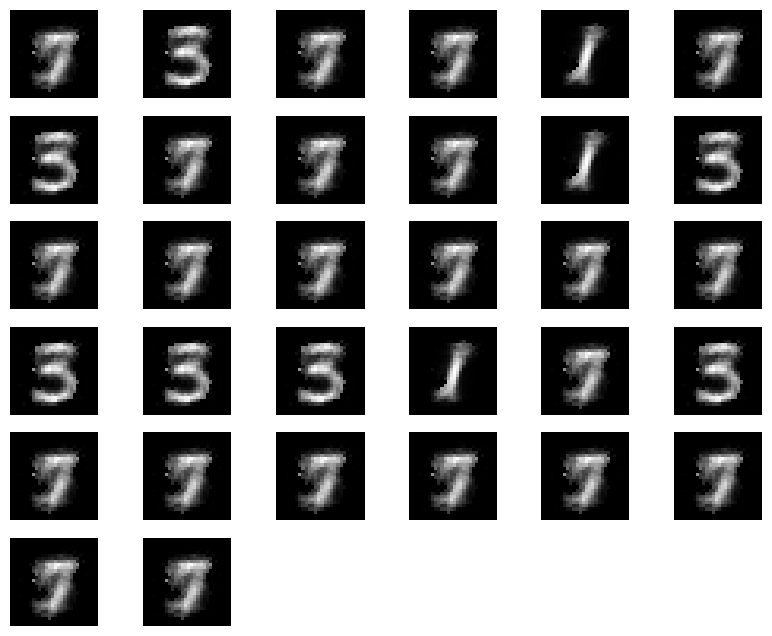

Original Images


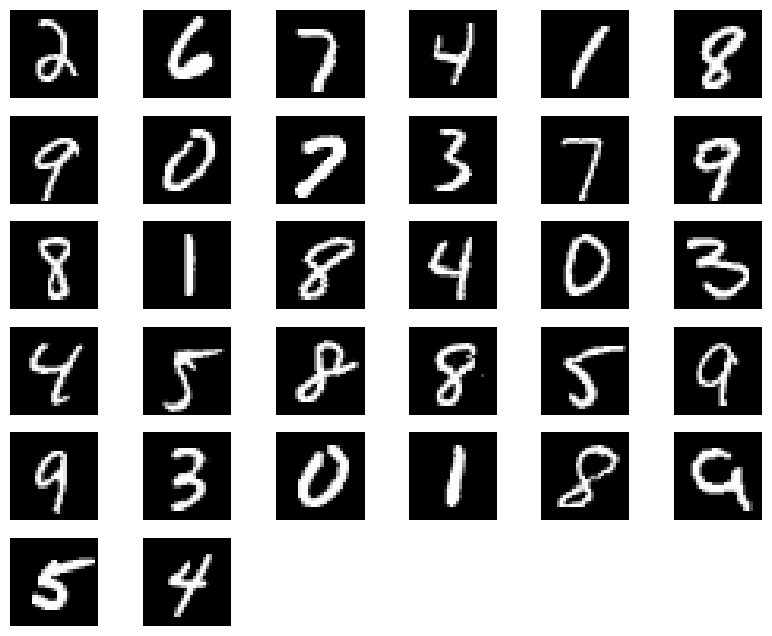

Restructured Image by AE


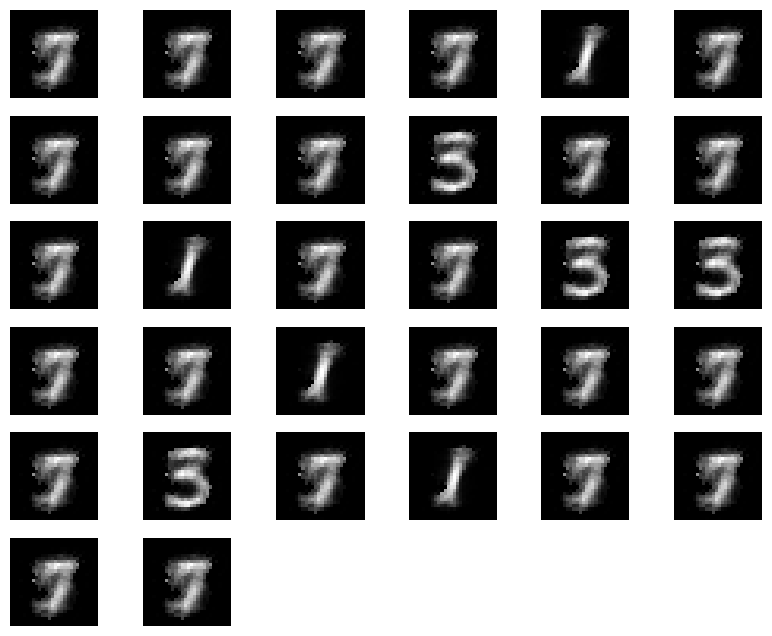

Original Images


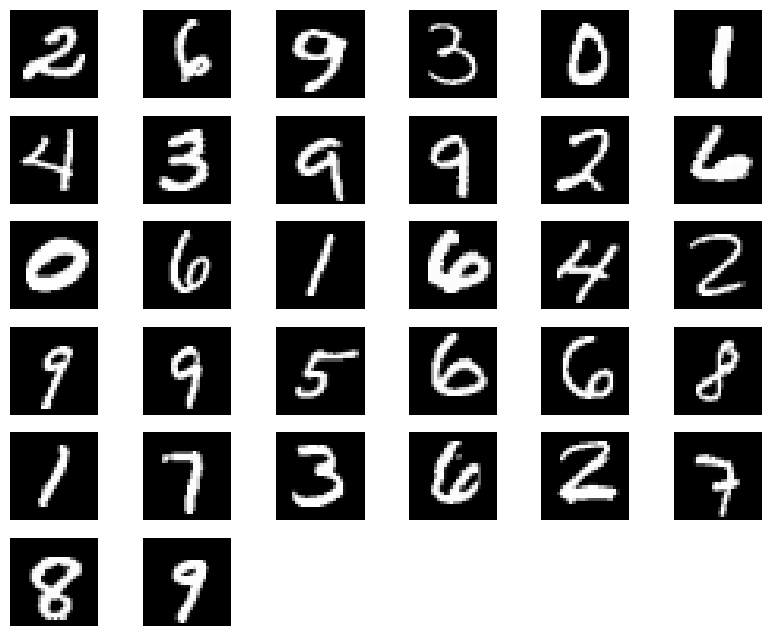

Restructured Image by AE


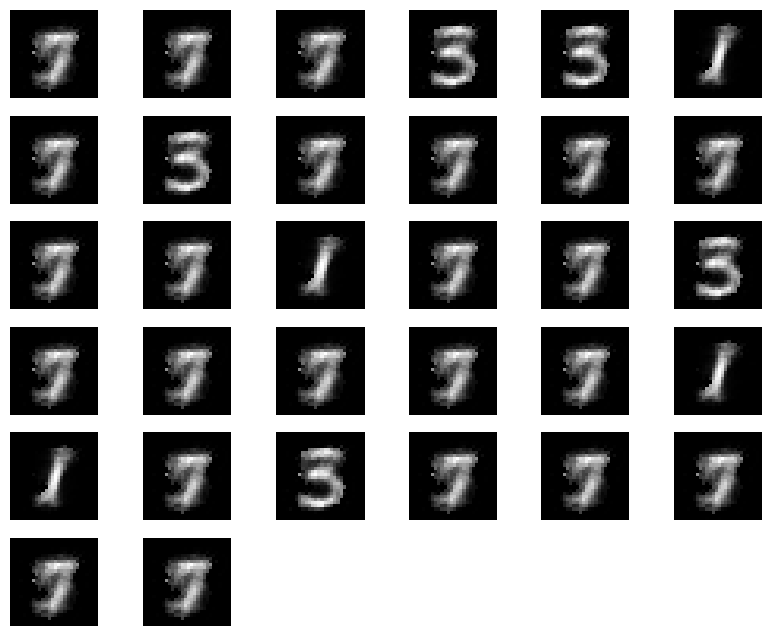

Original Images


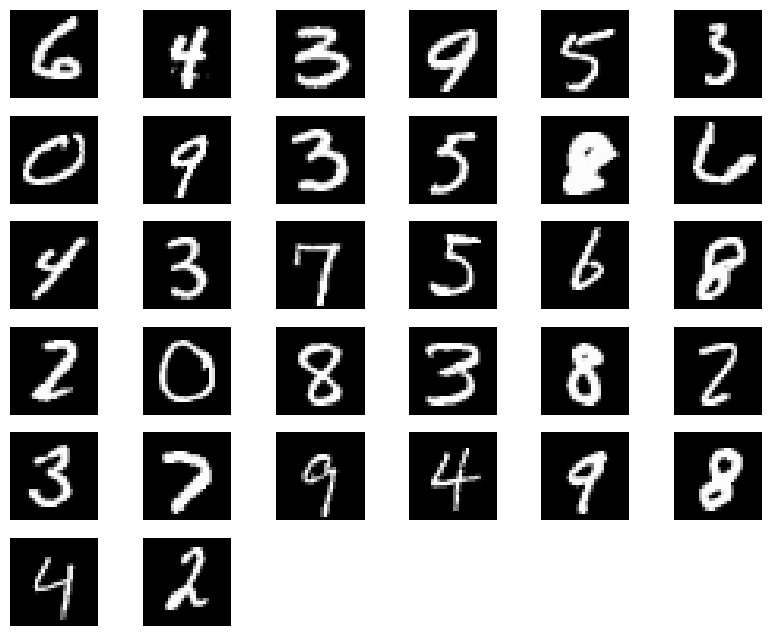

Restructured Image by AE


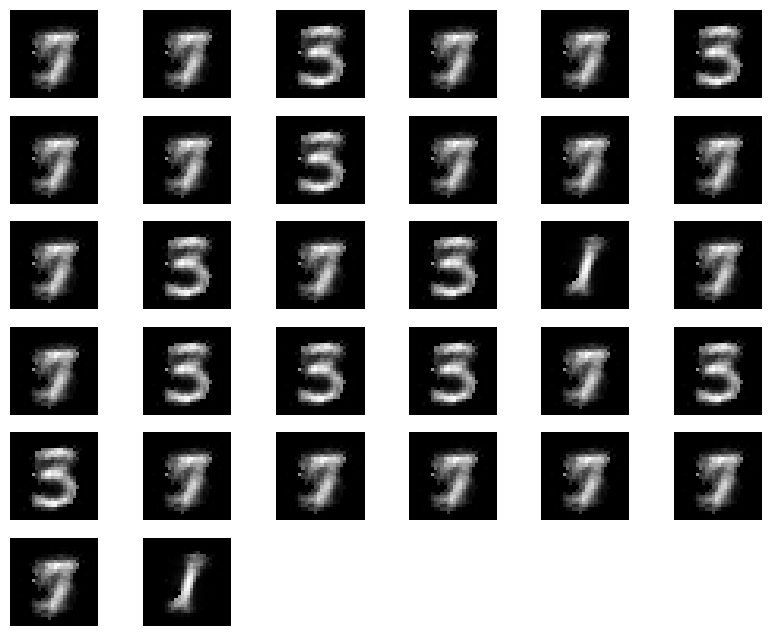

Original Images


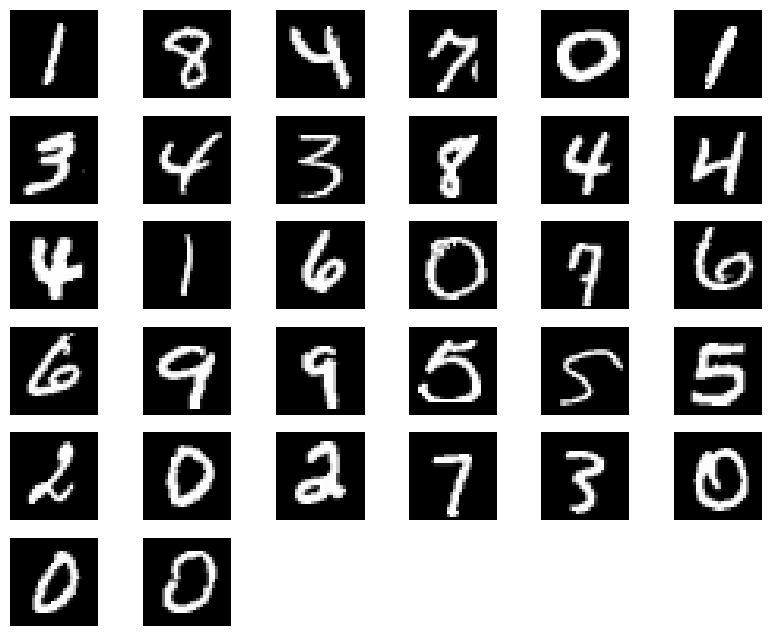

Restructured Image by AE


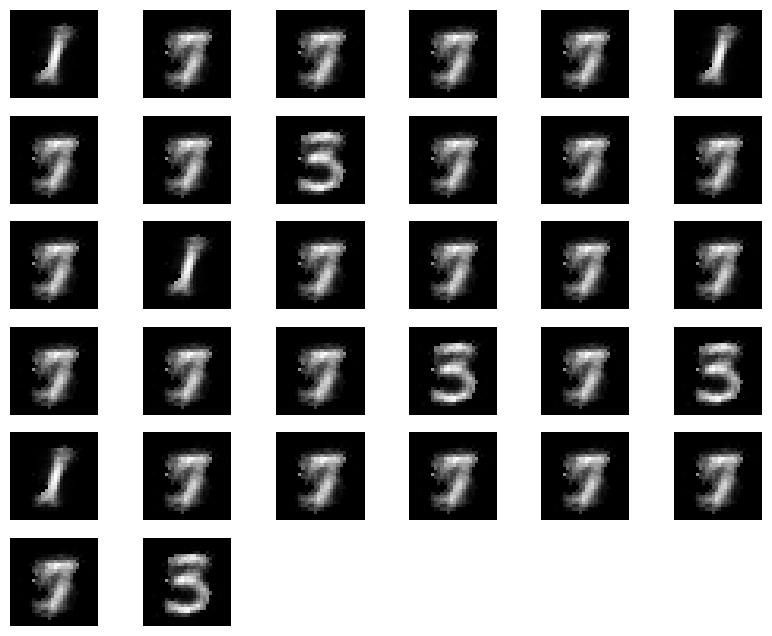

Original Images


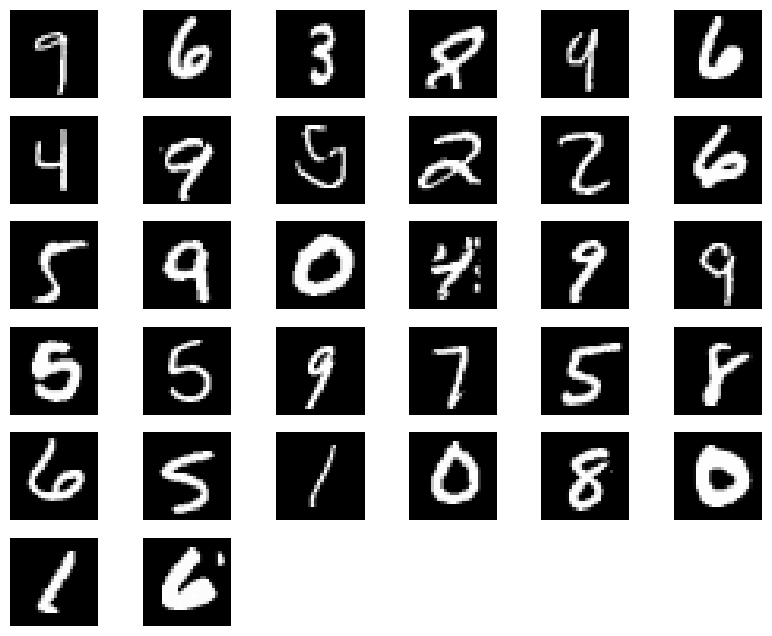

Restructured Image by AE


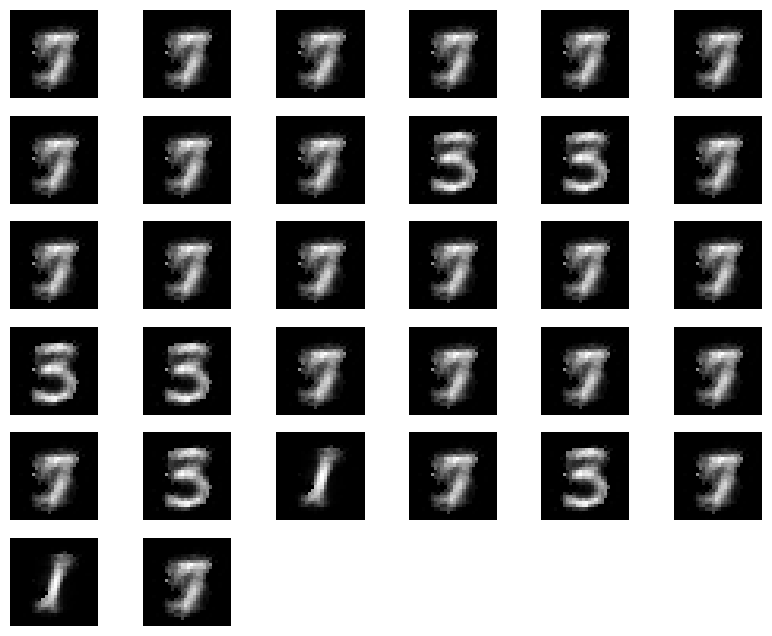

Original Images


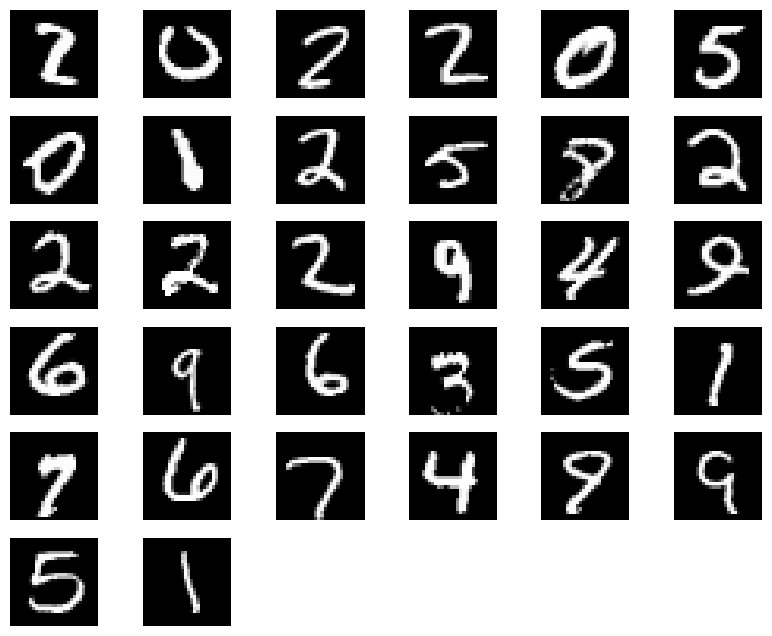

Restructured Image by AE


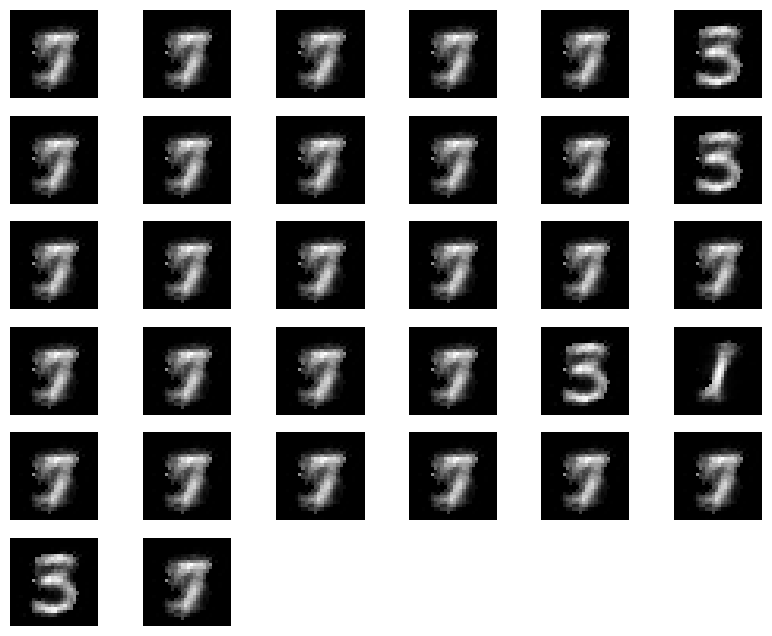

Original Images


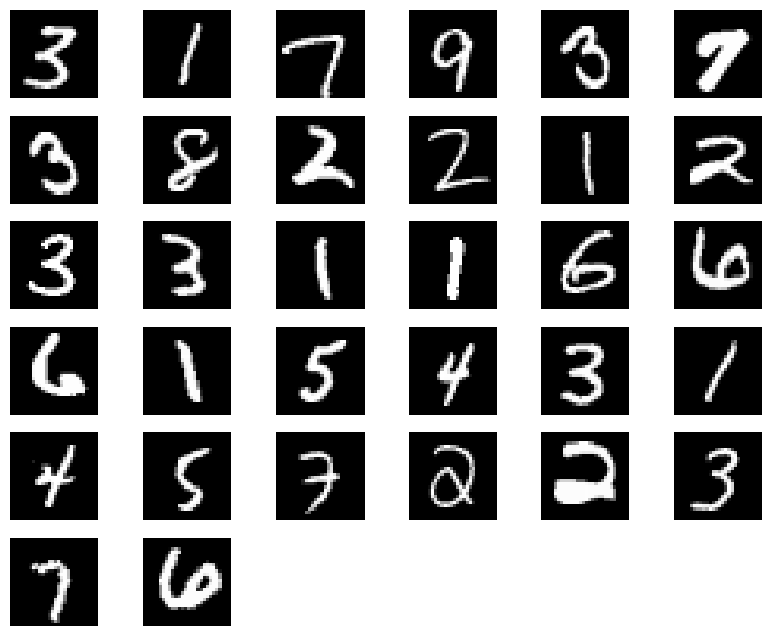

Restructured Image by AE


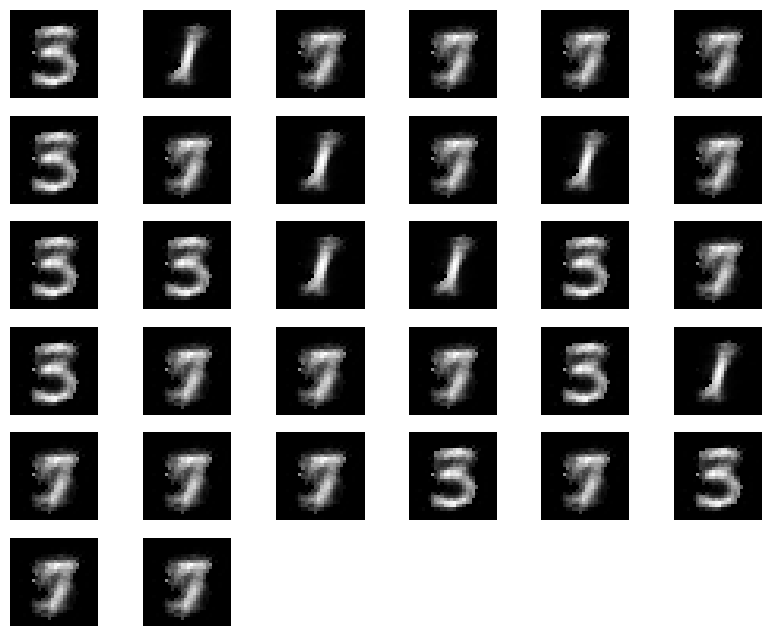

Original Images


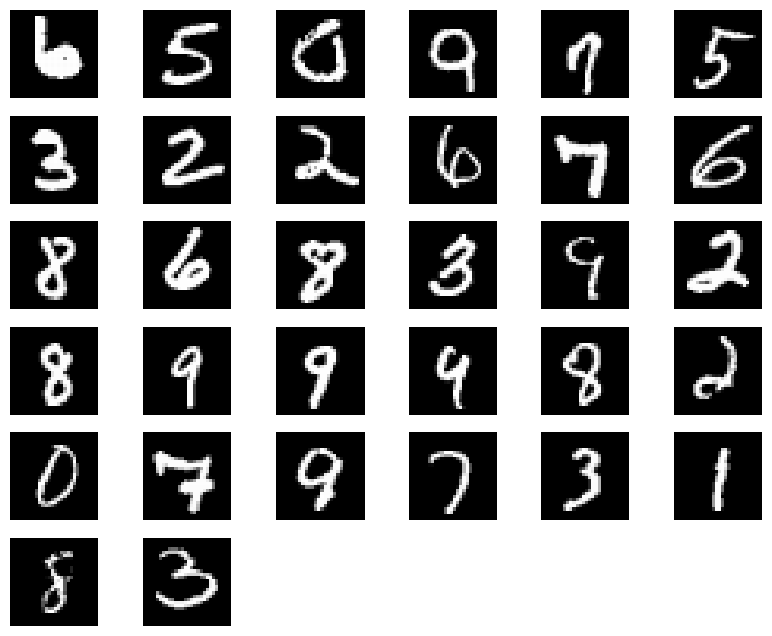

Restructured Image by AE


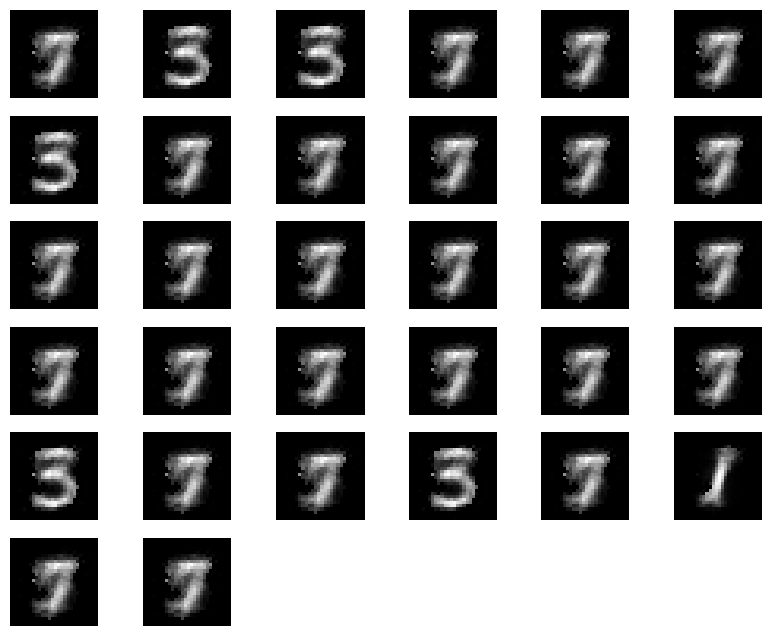

Original Images


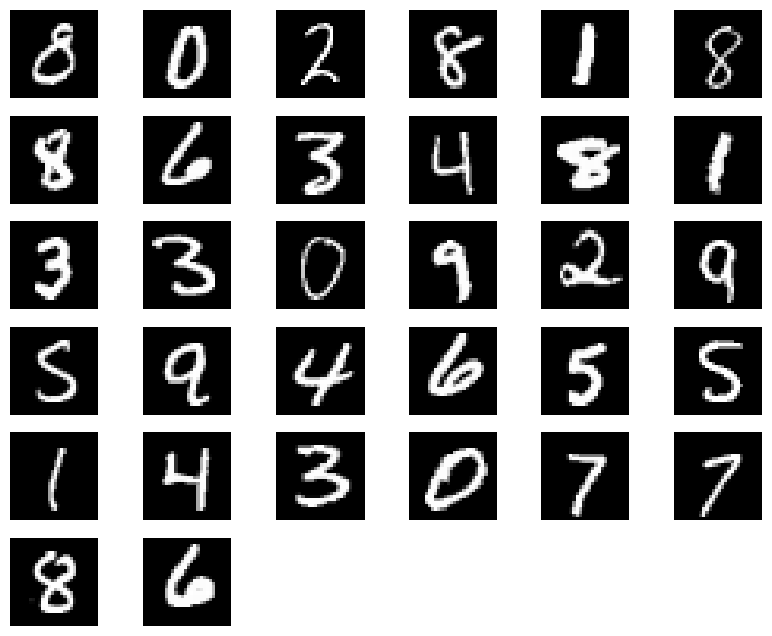

Restructured Image by AE


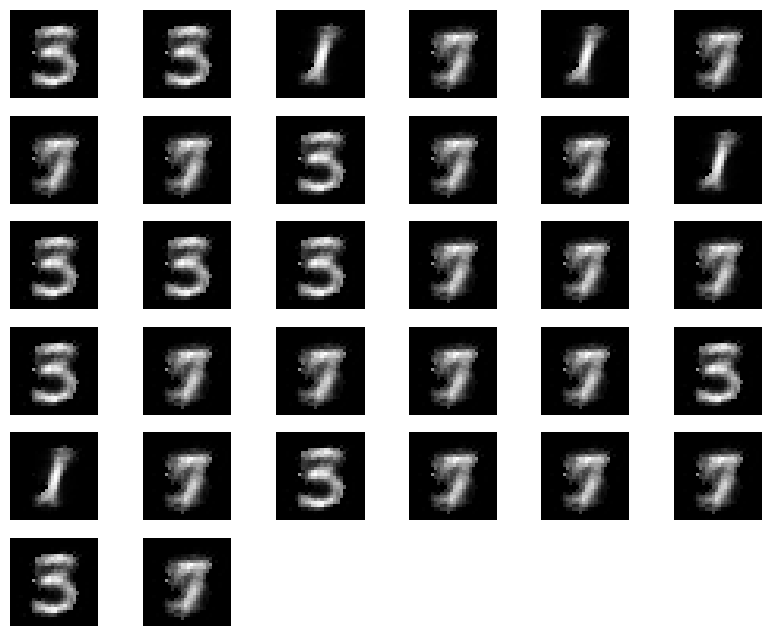

In [11]:
# 觀察decoder後的圖片跟原始圖片差異
# Settings
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Show images
def show_images(images):
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    for index, image in enumerate(images):
        plt.subplot(sqrtn, sqrtn, index+1)
        plt.imshow(image.reshape(28, 28))
        plt.axis('off')

model_ae.eval()
count = 10

# Test
with torch.no_grad():
    for i, (data, target) in enumerate(test_loader):
        inputs = data.view(-1, 28*28)
        print('Original Images')
        show_images(inputs)
        plt.show()
        # Forward
        decoder = model_ae(inputs.to(device))
        outputs = decoder.detach().cpu()
        print('Restructured Image by AE')
        show_images(outputs)
        plt.show()
        if i == 9:
            break

In [12]:
def calculate_threshold(model, data_loader, percentile=95):
    model.eval()  # 將模型設置為評估模式
    reconstruction_losses = []

    with torch.no_grad():  # 禁用梯度計算
        for images, _ in data_loader:
            inputs = images.view(-1, image_size)
            
            inputs = inputs.to(device)
            outputs = model(inputs)
            # 計算重建損失
            reconstruction_loss = torch.mean(torch.square(inputs - outputs))
            reconstruction_losses.append(reconstruction_loss.item())
    
    # 使用百分位數來計算閾值
    threshold = np.percentile(reconstruction_losses, percentile)
    return threshold

In [13]:
def test_model(model, loss_func, test_loader):
    best_acc = 0
    best_thres = 0
    
    for i in range(30):
        fac = i / 15
        threshold = calculate_threshold(model, test_loader, fac)
        with torch.no_grad():  # 禁用梯度計算
            model.eval()
            correct = 0  # 正確預測異常的數量
            total = 0  # 總共預測異常的數量

            for images, labels in test_loader:
                inputs = images.view(-1, image_size)

                # 1. 將數據傳入模型
                outputs = model(inputs)
                # 2. 計算重建損失
                test_loss = loss_func(outputs, inputs).item()

                # 3. 判斷是否為異常
                for k in range(len(labels)):
                    if labels[k] not in [1, 3, 5, 7]:  # 當預測機率低於閾值且真實標籤非正常類別時，視為異常
                        total += 1
                        if test_loss > threshold:
                            correct += 1

        accuracy = 100 * (correct / total) # 計算異常檢測的準確率
        if accuracy > best_acc:
            best_acc = accuracy
            best_thres = threshold
        print('Accuracy: {:.2f}%, Threshold: {:.6f} Abnormal Count: {}'.format(accuracy, threshold, correct))
    return best_acc, best_thres

# 使用測試函數對模型進行評估
accuracy_ae, best_threshold_ae = test_model(model_ae, loss_func_mse, test_loader)
print('Best Accuracy: {:.2f}%, Threshold: {:.6f}'.format(accuracy_ae, best_threshold_ae))

Accuracy: 99.21%, Threshold: 0.058084 Abnormal Count: 5888
Accuracy: 99.76%, Threshold: 0.055411 Abnormal Count: 5921
Accuracy: 100.00%, Threshold: 0.055279 Abnormal Count: 5935
Accuracy: 100.00%, Threshold: 0.055304 Abnormal Count: 5935
Accuracy: 100.00%, Threshold: 0.056562 Abnormal Count: 5935
Accuracy: 99.19%, Threshold: 0.057914 Abnormal Count: 5887
Accuracy: 98.72%, Threshold: 0.059340 Abnormal Count: 5859
Accuracy: 99.56%, Threshold: 0.058018 Abnormal Count: 5909
Accuracy: 99.11%, Threshold: 0.057957 Abnormal Count: 5882
Accuracy: 99.11%, Threshold: 0.058326 Abnormal Count: 5882
Accuracy: 99.76%, Threshold: 0.057426 Abnormal Count: 5921
Accuracy: 99.70%, Threshold: 0.057615 Abnormal Count: 5917
Accuracy: 98.57%, Threshold: 0.059163 Abnormal Count: 5850
Accuracy: 99.70%, Threshold: 0.057710 Abnormal Count: 5917
Accuracy: 98.26%, Threshold: 0.059180 Abnormal Count: 5832
Accuracy: 99.70%, Threshold: 0.058282 Abnormal Count: 5917
Accuracy: 97.27%, Threshold: 0.060474 Abnormal Count:

## Denosing Autoencoder（第三小題）

In [14]:
# define the NN architecture
class DAE(nn.Module):
    def __init__(self):
        super(DAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True))
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 28*28),
            nn.Sigmoid())
    
    def add_noise(self, img, noise_factor=0.25):
        # add random noise to the input images
        noisy_img = img + noise_factor * torch.randn_like(img)
        # Clip the images to be between 0 and 1
        noisy_img = torch.clamp(noisy_img, 0., 1.)
        
        return noisy_img

    def forward(self, x):
        noisy_inputs = self.add_noise(x)
        x = self.encoder(noisy_inputs.view(-1, 28*28))
        x = self.decoder(x)
        
        return x

# initialize the NN
model_dae = DAE()
print(model_dae)

loss_func_mse = nn.MSELoss()
optimizer = torch.optim.Adam(model_dae.parameters(), lr=LR)

DAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=784, bias=True)
    (3): Sigmoid()
  )
)


In [15]:
from torch.autograd import Variable

def fit_model(model, loss_func, optimizer, num_epochs, train_loader, val_loader):
    # Traning the Model
    #history-like list for store loss & acc value
    training_loss = []
    validation_loss = []
    for epoch in range(num_epochs):
        #training model & store loss & acc / epoch
        correct_train = 0
        total_train = 0
        for i, (images, labels) in enumerate(train_loader):
            inputs = images.view(-1, image_size).to(device)
            
            # 2.Clear gradients
            optimizer.zero_grad()
            # 3.Forward propagation
            outputs = model(inputs)
            # 4.Calculate softmax and cross entropy loss
            train_loss = loss_func(outputs, inputs)
            # 5.Calculate gradients
            train_loss.backward()
            # 6.Update parameters
            optimizer.step()
        
        # 11.store loss / epoch
        training_loss.append(train_loss.data)

        #evaluate model & store loss & acc / epoch
        correct_test = 0
        total_test = 0
        for images, labels in val_loader:
            inputs = images.view(-1, image_size).to(device)
            
            # 2.Forward propagation
            outputs = model(inputs)
            # 3.Calculate softmax and cross entropy loss
            val_loss = loss_func(outputs, inputs)
            
        # 11.store val_loss / epoch
        validation_loss.append(val_loss.data)
        print('Train Epoch: {}/{} Traing_Loss: {:.6f} Val_Loss: {:.6f}'.format(epoch+1, num_epochs, train_loss.data, val_loss.data))
    return training_loss, validation_loss


In [16]:
training_loss, validation_loss = fit_model(model_dae, loss_func_mse, optimizer, num_epochs, train_loader, val_loader)

Train Epoch: 1/9 Traing_Loss: 0.034177 Val_Loss: 0.030210
Train Epoch: 2/9 Traing_Loss: 0.025517 Val_Loss: 0.022676
Train Epoch: 3/9 Traing_Loss: 0.015583 Val_Loss: 0.010325
Train Epoch: 4/9 Traing_Loss: 0.023976 Val_Loss: 0.021034
Train Epoch: 5/9 Traing_Loss: 0.023011 Val_Loss: 0.020490
Train Epoch: 6/9 Traing_Loss: 0.023315 Val_Loss: 0.024293
Train Epoch: 7/9 Traing_Loss: 0.018893 Val_Loss: 0.019970
Train Epoch: 8/9 Traing_Loss: 0.020357 Val_Loss: 0.015108
Train Epoch: 9/9 Traing_Loss: 0.017135 Val_Loss: 0.022680


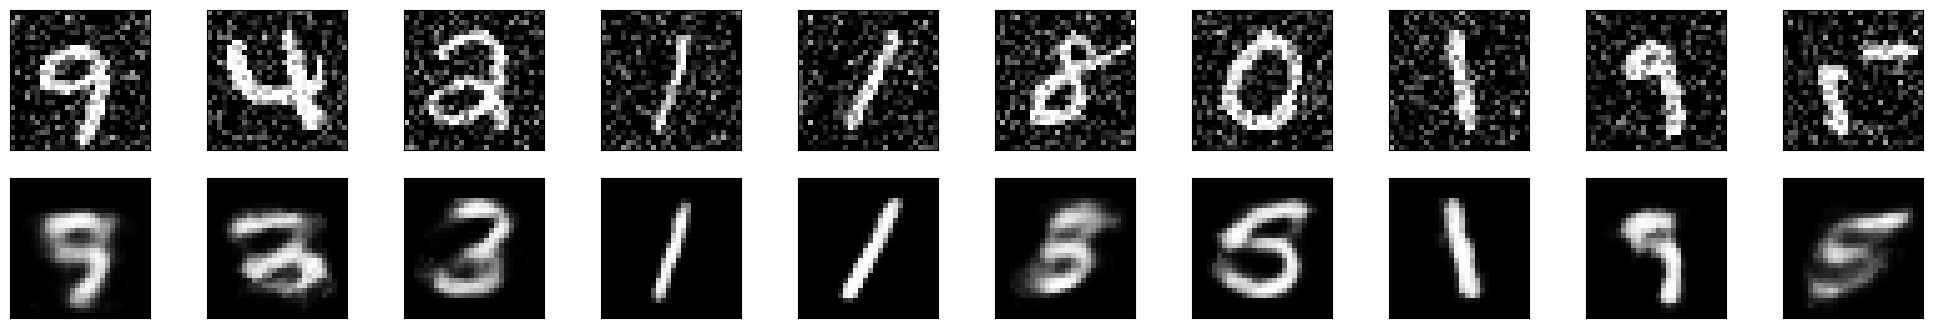

In [17]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)

noise_factor = 0.5

# use model's add_noise function to add noise to the test images
noisy_imgs = model_dae.add_noise(images)

# get sample outputs
output = model_dae(images.view(-1, image_size).to(device))
output = output.view(-1, 1, 28, 28)  # resize output to be a batch of images

# prep images for display
noisy_imgs = noisy_imgs.numpy()
output = output.detach().cpu().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for noisy_imgs, row in zip([noisy_imgs, output], axes):
    for img, ax in zip(noisy_imgs, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

In [18]:
def calculate_threshold(model, data_loader, percentile=95):
    model.eval()  # 將模型設置為評估模式
    reconstruction_losses = []
    
    with torch.no_grad():  # 禁用梯度計算
        for images, _ in data_loader:
            inputs = images.view(-1, image_size)
            
            inputs = inputs.to(device)
            outputs = model(inputs)
            # 計算重建損失
            reconstruction_loss = torch.mean(torch.square(inputs - outputs))
            reconstruction_losses.append(reconstruction_loss.item())
    
    # 使用百分位數來計算閾值
    threshold = np.percentile(reconstruction_losses, percentile)
    return threshold

In [19]:
def test_model(model, loss_func, test_loader):
    best_acc = 0
    best_thres = 0
    
    for i in range(30):
        fac = i / 15
        threshold = calculate_threshold(model, test_loader, fac)
        with torch.no_grad():  # 禁用梯度計算
            model.eval()
            correct = 0  # 正確預測異常的數量
            total = 0  # 總共預測異常的數量

            for images, labels in test_loader:
                inputs = images.view(-1, image_size)

                # 1. 將數據傳入模型
                outputs = model(inputs)
                # 2. 計算重建損失
                test_loss = loss_func(outputs, inputs).item()

                # 3. 判斷是否為異常
                for k in range(len(labels)):
                    if labels[k] not in [1, 3, 5, 7]:  # 當預測機率低於閾值且真實標籤非正常類別時，視為異常
                        total += 1
                        if test_loss > threshold:
                            correct += 1

        accuracy = 100 * (correct / total) # 計算異常檢測的準確率
        if accuracy > best_acc:
            best_acc = accuracy
            best_thres = threshold
        print('Accuracy: {:.2f}%, Threshold: {:.6f} Abnormal Count: {}'.format(accuracy, threshold, correct))
    return best_acc, best_thres

# 使用測試函數對模型進行評估
accuracy_dae, best_threshold_dae = test_model(model_dae, loss_func_mse, test_loader)
print('Best Accuracy: {:.2f}%, Threshold: {:.6f}'.format(accuracy_dae, best_threshold_dae))

Accuracy: 99.80%, Threshold: 0.028049 Abnormal Count: 5923
Accuracy: 100.00%, Threshold: 0.026586 Abnormal Count: 5935
Accuracy: 100.00%, Threshold: 0.026970 Abnormal Count: 5935
Accuracy: 99.49%, Threshold: 0.027169 Abnormal Count: 5905
Accuracy: 99.26%, Threshold: 0.027663 Abnormal Count: 5891
Accuracy: 99.01%, Threshold: 0.027396 Abnormal Count: 5876
Accuracy: 99.41%, Threshold: 0.029512 Abnormal Count: 5900
Accuracy: 99.85%, Threshold: 0.028567 Abnormal Count: 5926
Accuracy: 99.80%, Threshold: 0.028083 Abnormal Count: 5923
Accuracy: 98.96%, Threshold: 0.028237 Abnormal Count: 5873
Accuracy: 99.19%, Threshold: 0.028636 Abnormal Count: 5887
Accuracy: 98.87%, Threshold: 0.029312 Abnormal Count: 5868
Accuracy: 99.55%, Threshold: 0.028581 Abnormal Count: 5908
Accuracy: 99.06%, Threshold: 0.029066 Abnormal Count: 5879
Accuracy: 99.11%, Threshold: 0.028815 Abnormal Count: 5882
Accuracy: 99.11%, Threshold: 0.029674 Abnormal Count: 5882
Accuracy: 98.50%, Threshold: 0.030235 Abnormal Count: 

## Variational Autoencoder（第四小題）

In [20]:
class VAE(nn.Module):
    def __init__(self, image_size=image_size, h_dim=400, z_dim=20):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(image_size, h_dim)
        self.fc2 = nn.Linear(h_dim, z_dim) # 均值 向量
        self.fc3 = nn.Linear(h_dim, z_dim) # 保准方差 向量
        self.fc4 = nn.Linear(z_dim, h_dim)
        self.fc5 = nn.Linear(h_dim, image_size)
        
    # 編碼過程
    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc2(h), self.fc3(h)
    
    # 隨機生成隱含向量
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    # 解碼過程
    def decode(self, z):
        h = F.relu(self.fc4(z))
        return torch.sigmoid(self.fc5(h))  # 使用sigmoid函數將輸出限制在0到1之間
    
    # 整個前向傳播過程：編碼->解碼
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z)
        return x_reconst, mu, log_var
    
model = VAE().to(device)
print(model)

loss_func_mse = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

VAE(
  (fc1): Linear(in_features=784, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=20, bias=True)
  (fc3): Linear(in_features=400, out_features=20, bias=True)
  (fc4): Linear(in_features=20, out_features=400, bias=True)
  (fc5): Linear(in_features=400, out_features=784, bias=True)
)


In [21]:
import torch.nn.functional as F
from torchvision.utils import save_image

# 訓練模型
for epoch in range(num_epochs):
    for i, (x, _) in enumerate(train_loader):
        x = x.to(device).view(-1, image_size)
        x_reconst, mu, log_var = model(x)
        
        # 計算重構損失和KL散度
        reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        
        # 反向傳播和優化
        loss = reconst_loss + kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}" 
                   .format(epoch+1, num_epochs, i+1, len(train_loader), reconst_loss.item(), kl_div.item()))
    
    # 進行測試
    with torch.no_grad():
        # 隨機生成的圖像
        z = torch.randn(batch_size, 20).to(device)
        out = model.decode(z).view(-1, 1, 28, 28)

        # 重構的圖像
        out, _, _ = model(x)
        x_concat = torch.cat([x.view(-1, 1, 28, 28), out.view(-1, 1, 28, 28)], dim=3)

Epoch[1/9], Step [100/538], Reconst Loss: 4117.1304, KL Div: 257.1703
Epoch[1/9], Step [200/538], Reconst Loss: 4129.1738, KL Div: 392.9136
Epoch[1/9], Step [300/538], Reconst Loss: 3813.9812, KL Div: 393.0385
Epoch[1/9], Step [400/538], Reconst Loss: 3533.6157, KL Div: 342.8820
Epoch[1/9], Step [500/538], Reconst Loss: 3224.5669, KL Div: 376.4675
Epoch[2/9], Step [100/538], Reconst Loss: 3381.0125, KL Div: 406.1527
Epoch[2/9], Step [200/538], Reconst Loss: 3078.9006, KL Div: 409.2730
Epoch[2/9], Step [300/538], Reconst Loss: 3275.1826, KL Div: 481.9455
Epoch[2/9], Step [400/538], Reconst Loss: 3272.4526, KL Div: 409.1414
Epoch[2/9], Step [500/538], Reconst Loss: 3192.6438, KL Div: 379.0054
Epoch[3/9], Step [100/538], Reconst Loss: 2833.0952, KL Div: 376.3570
Epoch[3/9], Step [200/538], Reconst Loss: 2858.2947, KL Div: 432.3187
Epoch[3/9], Step [300/538], Reconst Loss: 3233.3906, KL Div: 412.7674
Epoch[3/9], Step [400/538], Reconst Loss: 2772.7156, KL Div: 422.9340
Epoch[3/9], Step [50

In [22]:
import numpy as np

def calculate_threshold(model, data_loader, percentile=95, loss=None):
    model.eval()  # 將模型設置為評估模式
    loss_values = []

    with torch.no_grad():  # 禁用梯度計算
        for images, _ in data_loader:
            inputs = images.view(-1, image_size).to(device)
            outputs, mu, log_var = model(inputs)

            # 計算總的損失
            if loss is not None:
                loss_value = loss(outputs, inputs).item()
            else:
                # 如果沒有提供特定的損失函數，則使用預設的二元交叉熵損失函數
                loss_value = F.binary_cross_entropy(outputs, inputs, reduction='sum').item()

            loss_values.append(loss_value)

    # 使用百分位數來計算閾值
    threshold = np.percentile(loss_values, percentile)
    return threshold

In [23]:
def test_model(model, loss_func, image_size, test_loader):
    best_acc = 0
    best_thres = 0
    
    for i in range(30):
        fac = i / 15
        threshold = calculate_threshold(model, test_loader, fac)
        with torch.no_grad():  # 禁用梯度計算
            model.eval()
            correct = 0  # 正確預測異常的數量
            total = 0  # 總共預測異常的數量
            
            for i, (x, labels) in enumerate(test_loader):
                x = x.to(device).view(-1, image_size)
                x_reconst, mu, log_var = model(x)

                # 計算重構損失和KL散度
                reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')
                kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

                # 反向傳播和優化
                loss = reconst_loss + kl_div

                # 判斷是否為異常
                for k in range(len(labels)):
                    if labels[k] not in [1, 3, 5, 7]:  # 當預測機率低於閾值且真實標籤非正常類別時，視為異常
                        total += 1
                        if loss > threshold:
                            correct += 1

        accuracy = 100 * (correct / total) # 計算異常檢測的準確率
        if accuracy > best_acc:
            best_acc = accuracy
            best_thres = threshold
        print('Accuracy: {:.2f}%, Threshold: {:.6f}, Abnormal Count: {}'.format(accuracy, threshold, correct))
    return best_acc, best_thres

# 使用測試函數對模型進行評估
accuracy_vae, best_threshold_vae = test_model(model, loss_func_mse, image_size, test_loader)
print('Best Accuracy: {:.2f}%, Best Threshold: {:.6f}'.format(accuracy_vae, best_threshold_vae))

Accuracy: 100.00%, Threshold: 2314.851562, Abnormal Count: 5935
Accuracy: 99.90%, Threshold: 2523.349531, Abnormal Count: 5929
Accuracy: 99.90%, Threshold: 2707.033797, Abnormal Count: 5929
Accuracy: 99.87%, Threshold: 3139.859072, Abnormal Count: 5927
Accuracy: 99.76%, Threshold: 3403.528689, Abnormal Count: 5921
Accuracy: 99.83%, Threshold: 3376.552148, Abnormal Count: 5925
Accuracy: 99.88%, Threshold: 3721.072637, Abnormal Count: 5928
Accuracy: 99.90%, Threshold: 3671.751754, Abnormal Count: 5929
Accuracy: 99.83%, Threshold: 3608.616807, Abnormal Count: 5925
Accuracy: 99.83%, Threshold: 3640.412736, Abnormal Count: 5925
Accuracy: 99.87%, Threshold: 3632.264346, Abnormal Count: 5927
Accuracy: 99.83%, Threshold: 3673.767475, Abnormal Count: 5925
Accuracy: 99.88%, Threshold: 3727.257439, Abnormal Count: 5928
Accuracy: 99.80%, Threshold: 3719.255172, Abnormal Count: 5923
Accuracy: 99.80%, Threshold: 3666.220383, Abnormal Count: 5923
Accuracy: 99.80%, Threshold: 3729.973477, Abnormal Cou

## Isolated Forest Method（第五小題）

In [24]:
# Set Hyper Parameters
batch_size = 100
epochs = 100
LR = 0.001
#batch_size = 32
n_iters = 5000
num_epochs = n_iters / (len(train_x) / batch_size)
num_epochs = int(num_epochs)
input_shape = (-1,1,28,28)

In [25]:
# Flatten the data since Isolation Forest doesn't work with 2D images directly
def flatten_tensor_dataset(loader):
    features = []
    targets = []
    for data, target in loader:
        data = data.view(data.size(0), -1)  # Flatten the images
        features.append(data)
        targets.append(target)

    features = torch.cat(features, dim=0)
    targets = torch.cat(targets, dim=0)
    return features, targets

X_train, y_train = flatten_tensor_dataset(train_loader)
X_val, y_val = flatten_tensor_dataset(val_loader)
X_test, y_test = flatten_tensor_dataset(test_loader)

In [26]:
from sklearn.ensemble import IsolationForest

# Convert tensors to numpy arrays for compatibility with scikit-learn
X_train_np = X_train.numpy()
X_test_np = X_test.numpy()

# Initialize Isolation Forest
iso_forest = IsolationForest(n_estimators=100, contamination='auto', random_state=42)

# Train the Isolation Forest on the flattened train data
iso_forest.fit(X_train_np)

IsolationForest(random_state=42)

In [27]:
# Use the trained model to make predictions on the test set
y_pred_test = iso_forest.predict(X_test_np)

# Convert predictions: 1 (normal) and -1 (anomaly) to match target classes
y_pred_test = np.where(y_pred_test == 1, 1, 0)  # 1 for 'normal', 0 for 'anomaly'

# Modify labels in y_test to match prediction labels: 1 for 'normal', 0 for 'anomaly'
#將測試集標籤（y_test）修改為0和1。如果標籤是1, 3, 5, 7中的一個，則轉為1（正常）；否則轉為0（異常）。
y_test_modified = np.isin(y_test.numpy(), [1, 3, 5, 7]).astype(int)

In [28]:
# Find the condition where the actual label is an anomaly but predicted as normal
actual_anomalies = np.isin(y_test.numpy(), [0, 2, 4, 6, 8])
predicted_as_normal = (y_pred_test == 0)

# Calculate the number of such cases
specific_anomalies_count = np.sum(actual_anomalies & predicted_as_normal)
same_count = np.sum(np.isin(y_test.numpy(), [1, 3, 5, 7]) & (y_pred_test == 1))
total = np.sum(y_pred_test)
print("異常數量 (label as [0,2,4,6,8] but predicted as [0,2,4,6,8]):", specific_anomalies_count)
# 计算准确率
accuracy_iso = (specific_anomalies_count + same_count) / total

# 格式化并打印准确率为百分比
print(f"Accuracy: {accuracy_iso:.2%}")

異常數量 (label as [0,2,4,6,8] but predicted as [0,2,4,6,8]): 2432
Accuracy: 86.75%


## Isolated Forest Method with pre-trained model（第六小題）

In [29]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1,16,kernel_size=(3,3)) # 第一卷積層
        self.dropout1 = nn.Dropout2d(0.25)  # 添加 dropout 層
        self.conv2 = nn.Conv2d(16,32,kernel_size=(3,3))
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2)) # 最大池化層
        self.dropout2 = nn.Dropout2d(0.25)  # 添加 dropout 層
        self.lin1 = nn.Linear(800,128)
        self.out = nn.Linear(128,10) # 模型的最後一層為線性層，用來處理 CNN 扁平化後的輸出
    
    def forward(self,x):
        x = self.conv1(x)
        x = nn.functional.relu(x) # 選用 ReLU 為激活函數
        x = self.dropout1(x)  # 添加 dropout 層
        x = self.maxpool(x)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = self.dropout2(x)  # 添加 dropout 層
        x = self.maxpool(x)
        x = x.flatten(start_dim=1) # 扁平化
        x = self.lin1(x) 
        x = nn.functional.relu(x)
        x = self.out(x)
        x = nn.functional.log_softmax(x,dim=1) # 使用 log_softmax()，以機率的形式進行分類
        return x

# Load or define your pre-trained model
pretrained_model = CNN()
pretrained_model.eval()  # Set the model to evaluation mode

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout2d(p=0.25, inplace=False)
  (lin1): Linear(in_features=800, out_features=128, bias=True)
  (out): Linear(in_features=128, out_features=10, bias=True)
)

In [30]:
def extract_features(data_loader, model):
    features = []
    labels = []

    # Ensure the model is in evaluation mode
    model.eval()

    # Disable gradient calculation for efficiency
    with torch.no_grad():
        for data, target in data_loader:
            #print(data.shape)
            data = data.view(-1,1,28,28)
            data = data.float()  # Convert data to float, necessary step

            # Ensure data is on the same device as the model (CPU/GPU)
            data = data.to(next(model.parameters()).device)
            
            # Forward pass to get the output from the model
            output = model(data)
            
            # Detach output and move to CPU, then convert to numpy
            output = output.detach().cpu().numpy()
            target = target.cpu().numpy()
            
            # Collect features and labels
            features.extend(output)
            labels.extend(target)
    print('finish')
    # Convert lists to numpy arrays for further processing
    return np.array(features), np.array(labels)

In [31]:
from sklearn.linear_model import LogisticRegression
# Assuming train_loader and test_loader are already defined and using the correct batch size and transformations
X_train, y_train = extract_features(train_loader, pretrained_model)
X_test, y_test = extract_features(test_loader, pretrained_model)


finish
finish


In [32]:
from sklearn.ensemble import IsolationForest

# Experiment with different parameters
clf = IsolationForest(n_estimators=200, contamination=0.05, max_samples='auto', random_state=42)
clf.fit(X_train)

# Predict anomalies on the test set
y_pred_test = clf.predict(X_test)

In [33]:
# Convert predictions: 1 (normal) and -1 (anomaly) to match target classes
y_pred_test = np.where(y_pred_test == 1, 1, 0)  # 1 for 'normal', 0 for 'anomaly'

# Modify labels in y_test to match prediction labels: 1 for 'normal', 0 for 'anomaly'
#將測試集標籤（y_test）修改為0和1。如果標籤是1, 3, 5, 7中的一個，則轉為1（正常）；否則轉為0（異常）。
y_test_modified = np.isin(y_test, [1, 3, 5, 7]).astype(int)

In [34]:
# Find the condition where the actual label is an anomaly but predicted as normal
actual_anomalies = np.isin(y_test, [0, 2, 4, 6, 8])
predicted_as_normal = (y_pred_test==0) #預測[0, 2, 4, 6, 8]

# Calculate the number of such cases
specific_anomalies_count = np.sum(actual_anomalies & predicted_as_normal)
same_count = np.sum(y_test)-np.sum(y_pred_test==0)

total = np.sum(y_test)
print("異常數量 (label as [0,2,4,6,8] but predicted as [0,2,4,6,8]):", specific_anomalies_count)

# 计算准确率
accuracy_pretrain = (specific_anomalies_count + same_count) / total

# 格式化并打印准确率为百分比
print(f"Accuracy: {accuracy_pretrain:.2%}")

異常數量 (label as [0,2,4,6,8] but predicted as [0,2,4,6,8]): 1187
Accuracy: 99.50%


## Compare and find a suitable threshold for each method（第七小題）

In [37]:
print("The classify：Best Accuracy: {:.2f}%, Threshold: {:.6f}".format(accuracy_clasify,best_threshold_clasify))
print("The AutoEncoder：Best Accuracy: {:.2f}%, Threshold: {:.6f}".format(accuracy_ae,best_threshold_ae))
print("The Denoising Autoencoder：Best Accuracy: {:.2f}%, Threshold: {:.6f}".format(accuracy_dae,best_threshold_dae))
print("The Variational Autoencoder：Best Accuracy: {:.2f}%, Threshold: {:.6f}".format(accuracy_vae,best_threshold_vae))
print(f"The Isolated Forest method：Best Accuracy: {accuracy_iso:.2%}")
print(f"The Isolated Forest method with pre-trained model：Best Accuracy: {accuracy_pretrain:.2%}")

The classify：Best Accuracy: 92.05%, Threshold: 0.999950
The AutoEncoder：Best Accuracy: 100.00%, Threshold: 0.055279
The Denoising Autoencoder：Best Accuracy: 100.00%, Threshold: 0.026586
The Variational Autoencoder：Best Accuracy: 100.00%, Threshold: 2314.851562
The Isolated Forest method：Best Accuracy: 86.75%
The Isolated Forest method with pre-trained model：Best Accuracy: 99.50%


### VAE和a denosing autoencoder透過學習資料的底層表示來偵測異常，而Isolated Forest透過隔離點的方式直接識別異常。